In [217]:
import sys

sys.path.insert(1, '../')
import results_utils
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
import colorama
from colorama import Fore
from Utils.utils import FileClass, ResultsClass
import glob
import numpy as np

ns = 10

In [218]:
def calc_CIC(ERRs):  # From errors of each culture
    factor = 1 / len(ERRs)
    CIC = 0
    for i in range(len(ERRs)):
        CIC += abs(ERRs[i] - min(ERRs))
    CIC = factor * CIC
    return CIC


def calc_ERR(acc):
    return 1 - (acc/100)

In [219]:
def extract_infos(accs):
    # accs are (3, ns) accuracies
    # we have to transform accuracies in errors
    errs = []
    for c_accs in accs:
        c_errs = []
        for acc in c_accs:
            c_errs.append(calc_ERR(acc))
        errs.append(c_errs)
    # now that we have errs we must estract the mean_err, the std_err,
    # the mean_CIC and the std_CIC from each culture
    mean_errs, std_errs = [], []
    for c_errs in errs:
        mean_errs.append(np.mean(c_errs))
        std_errs.append(np.std(c_errs))
    errs = np.asarray(errs, dtype=object).T
    CICs = []
    for errors in errs:
        CICs.append(calc_CIC(errors))
    mean_CIC = np.mean(CICs)
    std_CIC = np.std(CICs)
    #print(f'np.shape(mean_errs) is {np.shape(mean_errs)}')
    #print(f'np.shape(mean_CIC) is {np.shape(mean_CIC)}')
    return mean_errs, std_errs, mean_CIC, std_CIC


In [220]:
def plot_mitigated(cics, cicstds, errs, errstds, ref, center=(0, 0)):
    fig, ax = plt.subplots()
    cultures_colors = ['r', 'b', 'g']
    for j in range(3):
        plt.errorbar(errs[j],
                     cics[j],
                     yerr = cicstds[j],
                     xerr = errstds[j],
                     ecolor=cultures_colors[j],
                     estyle='dashdot',
                     marker='^')
    for tau in ref:
        circle = plt.Circle(center, tau, color='r')
        ax.add_patch(circle)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()


def plot_standard(alg_cics,
                  alg_cicstds,
                  alg_errs,
                  alg_errstds,
                  ref,
                  center=(0, 0),
                  title = 'Chinese Model',
                  labels = [['Chinese', 'French', 'Turkish'], ['LSVM', 'GSVM', 'RESNET']]):
    # Hyp: y has structure (3, 3, len(ref)), where
    # the first dim represents the specific algorithms used
    # the second dim represents the culture
    fig, ax = plt.subplots()
    cultures_colors = ['r', 'b', 'g']
    estyles = ['-', '--', '-.']

    for i in range(len(alg_cics)):
        for j in range(3):
            plt.plot(alg_errs[i][j],
                        alg_cics[i][j],
                        cultures_colors[j] + estyles[i],
                        #marker = '.',
                        linewidth = 1)
            plt.arrow(alg_errs[i][j][len(alg_errs)-1],
                        alg_cics[i][j][len(alg_errs)-1],
                        (alg_errs[i][j][len(alg_errs)-1]-alg_errs[i][j][len(alg_errs)-2])/20,
                        (alg_cics[i][j][len(alg_errs)-1]-alg_cics[i][j][len(alg_errs)-2])/20,
                        color = cultures_colors[j],
                        linestyle = estyles[i],
                        linewidth = 1, 
                        head_width= 0.01,
                        label = 'p_u increases')
    for pu in ref:
        circle = plt.Circle(center, pu, color='grey', fill=False, linestyle = ':')
        ax.add_patch(circle)
    # Limits 
    plt.xlim(0, max(max(max(max([alg_cics, alg_errs]))))+0.02)
    plt.ylim(0, max(max(max(max([alg_cics, alg_errs]))))+0.02)
    # axis name
    plt.xlabel('ERR')
    plt.ylabel('CIC')
    # Legend
    first_culture = mpatches.Patch(color='red', label=labels[0][0])
    second_culture = mpatches.Patch(color='blue', label=labels[0][1])
    third_culture = mpatches.Patch(color='green', label=labels[0][2])
    first_algorithm = mlines.Line2D([0], [0], label=labels[1][0], linestyle = estyles[0], linewidth = 1, color = 'black')
    second_algorithm = mlines.Line2D([0], [0],label=labels[1][1], linestyle = estyles[1], linewidth = 1, color = 'black')
    third_algorithm = mlines.Line2D([0], [0],label=labels[1][2], linestyle = estyles[2], linewidth = 1, color = 'black')
    arr = plt.scatter([],[],marker=r'$\rightarrow$', label='p_u increases', color='black', s=100) # dummy scatter to add an item to the legend
    plt.legend(handles=[first_culture, second_culture, third_culture, first_algorithm, second_algorithm, third_algorithm, arr])
    plt.title(title)
    #plt.show()

In [221]:
def get_errs_CICs(pts, model, ns):
    pt = pts[0]
    _0_accs = results_utils.retrieve_accs_standard(pt, model, ns)
    _0_errs, _0_std_errs, _0_CIC, _0_std_CICs = extract_infos(_0_accs)
    _0_CIC = [_0_CIC, _0_CIC, _0_CIC] # replicate cic info for each culture
    _0_std_CICs = [_0_std_CICs, _0_std_CICs, _0_std_CICs] # replicate cic info for each culture
    # pu = 0.5
    pt = pts[1]
    _5_accs = results_utils.retrieve_accs_standard(pt, model, ns)
    _5_errs, _5_std_errs, _5_CIC, _5_std_CICs = extract_infos(_5_accs)
    _5_CIC = [_5_CIC, _5_CIC, _5_CIC] # replicate cic info for each culture
    _5_std_CICs = [_5_std_CICs, _5_std_CICs, _5_std_CICs] # replicate cic info for each culture
    # pu = 0.1
    pt = pts[2]
    _10_accs = results_utils.retrieve_accs_standard(pt, model, ns)
    _10_errs, _10_std_errs, _10_CIC, _10_std_CICs = extract_infos(_10_accs)
    _10_CIC = [_10_CIC, _10_CIC, _10_CIC] # replicate cic info for each culture
    _10_std_CICs = [_10_std_CICs, _10_std_CICs, _10_std_CICs] # replicate cic info for each culture

    # For each culture I want to have each p_u
    _errs = []
    _std_errs = []
    _CICs = []
    _std_CICs = []
    
    for i in range(3):
        _errs.append([_0_errs[i], _5_errs[i], _10_errs[i] ])
        _std_errs.append([_0_std_errs[i], _5_std_errs[i], _10_std_errs[i]])
        _CICs.append([_0_CIC[i], _5_CIC[i], _10_CIC[i]])
        _std_CICs.append([_0_std_CICs[i], _5_std_CICs[i], _10_std_CICs[i]])
    #print(f'np.shape(_errs) is {np.shape(_errs)}')
    #print(f'np.shape(_CICs) is {np.shape(_CICs)}')
    return _errs, _std_errs, _CICs, _std_CICs

# Results Plot
## Analysis
Plots in analysis part are ERR/CIC plots for each culture where p_u varies.

Different algorithms are on the same plot
### LAMPS
#### CHINESE

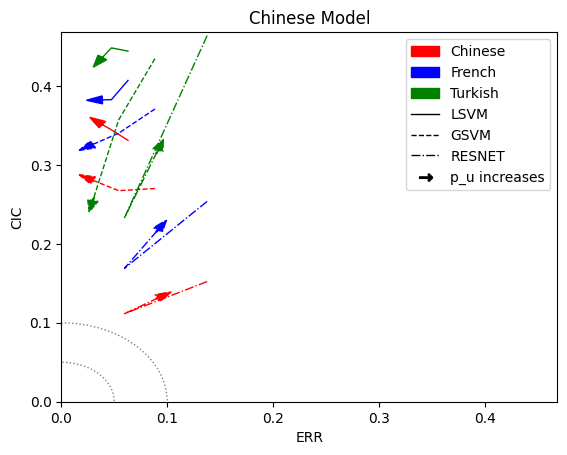

In [222]:
pus = [0, 0.05, 0.1]
p = '../standard'
# SVM LIN
model = 'lin_chin'
pts = []
pts.append(p + '/lin')
pts.append(p + '/50' + '/lin')
pts.append(p + '/9010' + '/lin')
lin_errs, lin_std_errs, lin_CICs, lin_std_CICs = get_errs_CICs(pts, model, ns)
# SVM RBF
model = 'rbf_chin'
pts = []
pts.append(p + '/rbf')
pts.append(p + '/50' + '/rbf')
pts.append(p + '/9010' + '/rbf')
rbf_errs, rbf_std_errs, rbf_CICs, rbf_std_CICs = get_errs_CICs(pts, model, ns)
# DL
model = 'l_chin'
p = '../deep_learning' 
pts = []
pts.append(p + '/lamp')
pts.append(p + '/9010/lamp/percent0,1')
pts.append(p + '/9010/lamp/percent0,05')
dl_errs, dl_std_errs, dl_CICs, dl_std_CICs = get_errs_CICs(pts, model, ns)

errs = [lin_errs, rbf_errs, dl_errs]
std_errs = [lin_std_errs, rbf_std_errs, dl_std_errs]
CICs = [lin_CICs, rbf_CICs, dl_CICs]
std_CICs = [lin_std_CICs, rbf_std_CICs, dl_std_CICs]
title = 'Chinese Model'
labels = [['Chinese', 'French', 'Turkish'], ['LSVM', 'GSVM', 'RESNET']]
plot_standard(errs, std_errs, CICs, std_CICs, pus , title = title, labels = labels, center = (0,0))


#### FRENCH

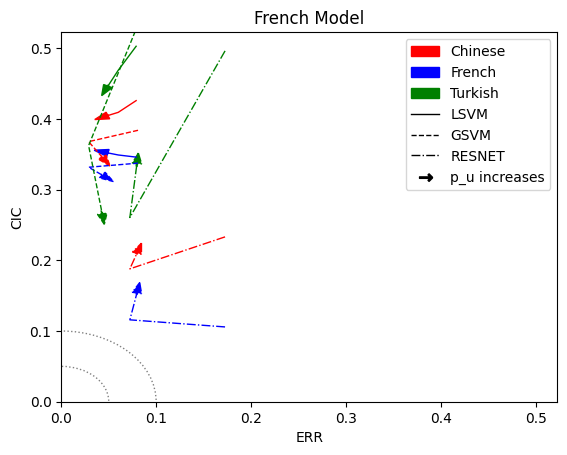

In [223]:
# SVM LIN
p = '../standard/'
model = 'lin_fren'
pts = []
pts.append(p + '/lin')
pts.append(p + '/50' + '/lin')
pts.append(p + '/9010' + '/lin')
lin_errs, lin_std_errs, lin_CICs, lin_std_CICs = get_errs_CICs(pts, model, ns)
# SVM RBF
model = 'rbf_fren'
pts = []
pts.append(p + '/rbf')
pts.append(p + '/50' + '/rbf')
pts.append(p + '/9010' + '/rbf')
rbf_errs, rbf_std_errs, rbf_CICs, rbf_std_CICs = get_errs_CICs(pts, model, ns)
# DL
model = 'l_fren'
p = '../deep_learning' 
pts = []
pts.append(p + '/lamp')
pts.append(p + '/9010/lamp/percent0,1')
pts.append(p + '/9010/lamp/percent0,05')
dl_errs, dl_std_errs, dl_CICs, dl_std_CICs = get_errs_CICs(pts, model, ns)

errs = [lin_errs, rbf_errs, dl_errs]
std_errs = [lin_std_errs, rbf_std_errs, dl_std_errs]
CICs = [lin_CICs, rbf_CICs, dl_CICs]
std_CICs = [lin_std_CICs, rbf_std_CICs, dl_std_CICs]
title = 'French Model'
labels = [['Chinese', 'French', 'Turkish'], ['LSVM', 'GSVM', 'RESNET']]
plot_standard(errs, std_errs, CICs, std_CICs, pus , title = title, labels = labels, center = (0,0))

#### TURKISH

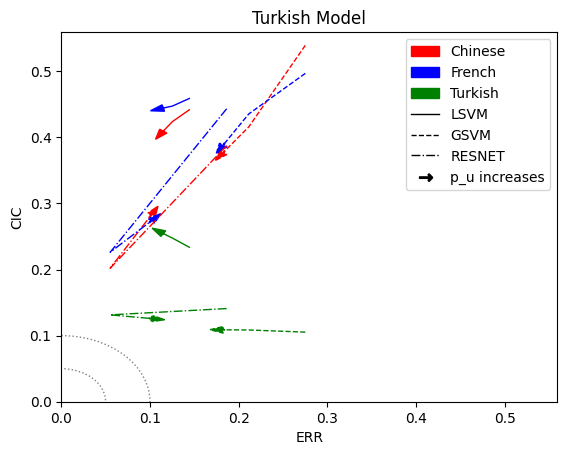

In [224]:
# SVM LIN
p = '../standard/'
model = 'lin_tur'
pts = []
pts.append(p + '/lin')
pts.append(p + '/50' + '/lin')
pts.append(p + '/9010' + '/lin')
lin_errs, lin_std_errs, lin_CICs, lin_std_CICs = get_errs_CICs(pts, model, ns)
# SVM RBF
model = 'rbf_tur'
pts = []
pts.append(p + '/rbf')
pts.append(p + '/50' + '/rbf')
pts.append(p + '/9010' + '/rbf')
rbf_errs, rbf_std_errs, rbf_CICs, rbf_std_CICs = get_errs_CICs(pts, model, ns)
# DL
model = 'l_tur'
p = '../deep_learning' 
pts = []
pts.append(p + '/lamp')
pts.append(p + '/9010/lamp/percent0,1')
pts.append(p + '/9010/lamp/percent0,05')
dl_errs, dl_std_errs, dl_CICs, dl_std_CICs = get_errs_CICs(pts, model, ns)

errs = [lin_errs, rbf_errs, dl_errs]
std_errs = [lin_std_errs, rbf_std_errs, dl_std_errs]
CICs = [lin_CICs, rbf_CICs, dl_CICs]
std_CICs = [lin_std_CICs, rbf_std_CICs, dl_std_CICs]
title = 'Turkish Model'
labels = [['Chinese', 'French', 'Turkish'], ['LSVM', 'GSVM', 'RESNET']]
plot_standard(errs, std_errs, CICs, std_CICs, pus , title = title, labels = labels, center = (0,0))

## Mitigation
Plots in mitigation part are ERR/CIC plots for each culture where for a certain p_u varies gamma